In [5]:
# import numpy as np
# from numpy import array
# import matplotlib.pyplot as plt
# %matplotlib inline

# import string
# import os
# import glob
# from PIL import Image
# from time import time

# from keras import Input, layers
# from keras import optimizers
# # from keras.optimizers import Adam
# from keras.preprocessing import sequence
# from keras.preprocessing import image
# from keras.preprocessing.text import Tokenizer
# from keras.preprocessing.sequence import pad_sequences
# from keras.layers import LSTM, Embedding, Dense, Activation, Flatten, Reshape, Dropout
# from keras.layers.wrappers import Bidirectional
# from keras.layers.merge import add
# from keras.applications.inception_v3 import InceptionV3
# from keras.applications.inception_v3 import preprocess_input
# from keras.models import Model
# # from keras.utils import to_categorical
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.models import Model
from keras.preprocessing.sequence import pad_sequences
#from keras.utils import to_categorical
import numpy as np
from numpy import array
import pandas as pd
import cv2
from glob import glob
import PIL
import time
from tqdm import tqdm
import os

In [8]:
image_path = "C:/Users/crahu/Downloads/Flikr/Images/"
images = glob(image_path + "*.jpg")
len(images)

8091

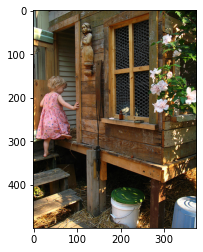

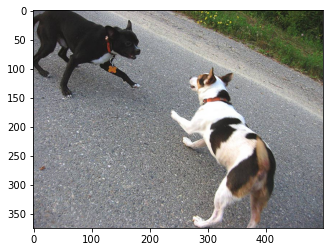

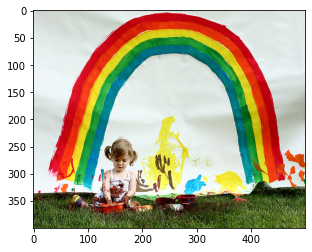

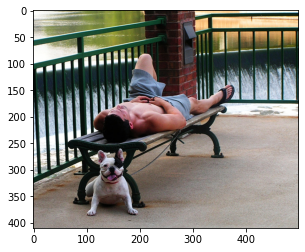

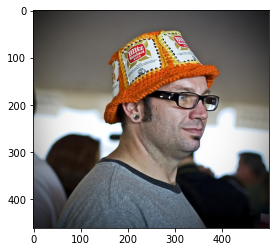

In [9]:
for i in range(5):
    plt.figure()
    image = cv2.imread(images[i])
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    plt.imshow(image)

In [11]:
def load(filename):
    file = open(filename, 'r')
    text = file.read()
    file.close()
    return text

file = "C:/Users/crahu/Downloads/Flikr/captions.txt"
info = load(file)
print(info[:484])

image,caption
1000268201_693b08cb0e.jpg,A child in a pink dress is climbing up a set of stairs in an entry way .
1000268201_693b08cb0e.jpg,A girl going into a wooden building .
1000268201_693b08cb0e.jpg,A little girl climbing into a wooden playhouse .
1000268201_693b08cb0e.jpg,A little girl climbing the stairs to her playhouse .
1000268201_693b08cb0e.jpg,A little girl in a pink dress going into a wooden cabin .
1001773457_577c3a7d70.jpg,A black dog and a spotted dog are fighting



In [14]:
file = "C:/Users/crahu/Downloads/Flikr/captions1.txt"
info = load(file)
print(info[:470])

1000268201_693b08cb0e.jpg,A child in a pink dress is climbing up a set of stairs in an entry way .
1000268201_693b08cb0e.jpg,A girl going into a wooden building .
1000268201_693b08cb0e.jpg,A little girl climbing into a wooden playhouse .
1000268201_693b08cb0e.jpg,A little girl climbing the stairs to her playhouse .
1000268201_693b08cb0e.jpg,A little girl in a pink dress going into a wooden cabin .
1001773457_577c3a7d70.jpg,A black dog and a spotted dog are fighting



In [15]:
### Convert the data into a dictionary
def load_captions(info):
    dict_1 = dict()
    count = 0
    for line in info.split('\n'):
        
        
        splitter = line.split('.jpg,')
#         print(splitter)
        # The image_code and image_captions are the list of the images with their respective captions
        image_code, image_caption = splitter[0], splitter[1]
        
        # Create dictionary
        if image_code not in dict_1:
            dict_1[image_code] = list()
            
        dict_1[image_code].append(image_caption)
        
    return dict_1

data = load_captions(info)
print(len(data))

8091


In [16]:
list(data.keys())[:5]

['1000268201_693b08cb0e',
 '1001773457_577c3a7d70',
 '1002674143_1b742ab4b8',
 '1003163366_44323f5815',
 '1007129816_e794419615']

In [17]:
data['1000268201_693b08cb0e']

['A child in a pink dress is climbing up a set of stairs in an entry way .',
 'A girl going into a wooden building .',
 'A little girl climbing into a wooden playhouse .',
 'A little girl climbing the stairs to her playhouse .',
 'A little girl in a pink dress going into a wooden cabin .']

In [18]:
#### Convert words to lower case 
def cleanse_data(data):
    dict_2 = dict()
    for key, value in data.items():
        for i in range(len(value)):
            lines = ""
            line1 = value[i]
            for j in line1.split():
                if len(j) < 2:
                    continue
                j = j.lower()
                lines += j + " "
            if key not in dict_2:
                dict_2[key] = list()
            
            dict_2[key].append(lines)
            
    return dict_2

data2 = cleanse_data(data)
print(len(data2)) 

8091


In [19]:
#### Create a vocabulary list of all the unique words
def vocabulary(data2):
    all_desc = set()
    for key in data2.keys():
        [all_desc.update(d.split()) for d in data2[key]]
    return all_desc

# summarize vocabulary
vocabulary_data = vocabulary(data2)
print(len(vocabulary_data))

9148


In [22]:
def save_dict(data2, filename):
    lines = list()
    for key, value in data2.items():
        for desc in value:
            lines.append(key + ' ' + desc)
    data = '\n'.join(lines)
    file = open(filename, 'w')
    file.write(data)
    file.close()

save_dict(data2, 'C:/Users/crahu/Downloads/Flikr/captions1.txt')

In [23]:
images = 'C:/Users/crahu/Downloads/Flikr/Images/'
img = glob(images + '*.jpg')
print(len(img))

def preprocess(image_path):
    # Convert all the images to size 299x299 as expected by the inception v3 model
    img = keras.preprocessing.image.load_img(image_path, target_size=(299, 299))
    # Convert PIL image to numpy array of 3-dimensions
    x = keras.preprocessing.image.img_to_array(img)
    # Add one more dimension
    x = np.expand_dims(x, axis=0)
    # pre-process the images using preprocess_input() from inception module
    x = keras.applications.inception_v3.preprocess_input(x)
    return x

8091


In [24]:
# Load the inception v3 model
input1 = InceptionV3(weights='imagenet')

# Create a new model, by removing the last layer (output layer) from the inception v3
model = Model(input1.input, input1.layers[-2].output)

model.summary()

96124928/96112376 [==============================] - 2s 0us/step
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 299, 299, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 149, 149, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 149, 149, 32  96         ['conv2d[0][0]']                 
 alization)                  

In [27]:
def encode(image):
    image = preprocess(image) # preprocess the image
    fea_vec = model.predict(image) # Get the encoding vector for the image
    fea_vec = np.reshape(fea_vec, fea_vec.shape[1]) # reshape from (1, 2048) to (2048, )
    return fea_vec
    
encoding = {}

for i in tqdm(img):
    encoding[i[len(images):]] = encode(i)
    
import pickle

# Save the features in the images1 pickle file
with open("images1.pkl", "wb") as encoded_pickle:
    pickle.dump(encoding, encoded_pickle)

100%|██████████████████████████████████████████████████████████████████████████████| 8091/8091 [12:55<00:00, 10.43it/s]


In [28]:
# Create a list of all the training captions

all_train_captions = []

for key, val in data2.items():
    for cap in val:
        all_train_captions.append(cap)
        
len(all_train_captions)

# Consider only words which occur at least 10 times in the corpus

word_count_threshold = 10
word_counts = {}
nsents = 0

for sent in all_train_captions:
    nsents += 1
    for w in sent.split(' '):
        word_counts[w] = word_counts.get(w, 0) + 1

vocab = [w for w in word_counts if word_counts[w] >= word_count_threshold]
print('preprocessed words %d -> %d' % (len(word_counts), len(vocab)))

# Converting the words to indices and vice versa.

ixtoword = {}
wordtoix = {}

ix = 1
for w in vocab:
    wordtoix[w] = ix
    ixtoword[ix] = w
    ix += 1
    
vocab_size = len(ixtoword) + 1 # one for appended 0's
vocab_size

# Save the words to index and index to word as pickle files

with open("words.pkl", "wb") as encoded_pickle:
    pickle.dump(wordtoix, encoded_pickle)
    
with open("words1.pkl", "wb") as encoded_pickle:
    pickle.dump(ixtoword, encoded_pickle)
    
# convert a dictionary of clean descriptions to a list of descriptions

def to_lines(descriptions):
    all_desc = list()
    for key in descriptions.keys():
        [all_desc.append(d) for d in descriptions[key]]
    return all_desc

# calculate the length of the description with the most words
def max_length(descriptions):
    lines = to_lines(descriptions)
    return max(len(d.split()) for d in lines)

# determine the maximum sequence length
max_length = max_length(data2)
print('Description Length: %d' % max_length)

preprocessed words 9149 -> 1975
Description Length: 33


In [29]:
def data_generator(descriptions, photos, wordtoix, max_length, num_photos_per_batch):
    X1, X2, y = list(), list(), list()
    n=0
    # loop for ever over images
    while 1:
        for key, desc_list in descriptions.items():
            n+=1
            # retrieve the photo feature
            photo = photos[key+'.jpg']
            for desc in desc_list:
                # encode the sequence
                seq = [wordtoix[word] for word in desc.split(' ') if word in wordtoix]
                # split one sequence into multiple X, y pairs
                for i in range(1, len(seq)):
                    # split into input and output pair
                    in_seq, out_seq = seq[:i], seq[i]
                    # pad input sequence
                    in_seq = pad_sequences([in_seq], maxlen=max_length)[0]
                    # encode output sequence
                    out_seq = to_categorical([out_seq], num_classes=vocab_size)[0]
                    # store
                    X1.append(photo)
                    X2.append(in_seq)
                    y.append(out_seq)
            # yield the batch data
            if n==num_photos_per_batch:
                yield ([array(X1), array(X2)], array(y))
                X1, X2, y = list(), list(), list()
                n=0

In [30]:
embeddings_index = {} # empty dictionary
f = open("C:/Users/crahu/Downloads/glove.6B.200d.txt(1)/glove.6B.200d.txt", encoding="utf-8")

for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()
print('Found %s word vectors.' % len(embeddings_index))

embedding_dim = 200

# Get 200-dim dense vector for each of the 10000 words in out vocabulary
embedding_matrix = np.zeros((vocab_size, embedding_dim))

for word, i in wordtoix.items():
    #if i < max_words:
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # Words not found in the embedding index will be all zeros,
        embedding_matrix[i] = embedding_vector
        
embedding_matrix.shape

Found 400000 word vectors.


(1976, 200)

In [50]:
from tensorflow.keras.layers import Dense, Input, Conv2D, MaxPool2D, LSTM, add
from tensorflow.keras.layers import Activation, Dropout, Flatten, Embedding
from tensorflow.keras.models import Model

inputs1 = Input(shape=(2048,))
fe1 = Dropout(0.5)(inputs1)
fe2 = Dense(256, activation='relu')(fe1)

inputs2 = Input(shape=(max_length,))
se1 = Embedding(vocab_size, embedding_dim, mask_zero=True)(inputs2)
se2 = Dropout(0.5)(se1)
se3 = LSTM(256)(se2)

decoder1 = add([fe2, se3])
decoder2 = Dense(256, activation='relu')(decoder1)
outputs = Dense(vocab_size, activation='softmax')(decoder2)

model = Model(inputs=[inputs1, inputs2], outputs=outputs)
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_5 (InputLayer)           [(None, 33)]         0           []                               
                                                                                                  
 input_4 (InputLayer)           [(None, 2048)]       0           []                               
                                                                                                  
 embedding_1 (Embedding)        (None, 33, 200)      395200      ['input_5[0][0]']                
                                                                                                  
 dropout_2 (Dropout)            (None, 2048)         0           ['input_4[0][0]']                
                                                                                            

In [51]:
from tensorflow.keras.utils import to_categorical
model.layers[2].set_weights([embedding_matrix])
model.layers[2].trainable = False

model.compile(loss='categorical_crossentropy', optimizer='adam')

epochs = 100
number_pics_per_bath = 3
steps = len(data2)//number_pics_per_bath

features = pickle.load(open("images1.pkl", "rb"))

# https://stackoverflow.com/questions/58352326/running-the-tensorflow-2-0-code-gives-valueerror-tf-function-decorated-functio

tf.config.run_functions_eagerly(True)

for i in range(epochs):
    generator = data_generator(data2, features, wordtoix, max_length, number_pics_per_bath)
    model.fit(generator, epochs=1, steps_per_epoch=steps, verbose=1)
    model.save('model_' + str(i) + '.h5')

2697/2697 [==============================] - 841s 312ms/step - loss: 2.3927


In [52]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.sequence import pad_sequences
import numpy as np
import matplotlib.pyplot as plt
import pickle

In [65]:
features = pickle.load(open("images1.pkl", "rb"))
model = load_model('model_50.h5')
images = "C:/Users/crahu/Downloads/Flikr/Images/"
max_length = 33
words_to_index = pickle.load(open("words.pkl", "rb"))
index_to_words = pickle.load(open("words1.pkl", "rb"))

In [66]:
def Image_Caption(picture):
    in_text = 'startseq'
    for i in range(max_length):
        sequence = [words_to_index[w] for w in in_text.split() if w in words_to_index]
        sequence = pad_sequences([sequence], maxlen=max_length)
        yhat = model.predict([picture,sequence], verbose=0)
        yhat = np.argmax(yhat)
        word = index_to_words[yhat]
        in_text += ' ' + word
        if word == 'endseq':
            break
    final = in_text.split()
    final = final[1:-1]
    final = ' '.join(final)
    return final

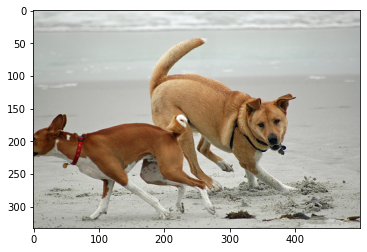

Caption: identical dogs are playing in the


In [67]:
z = 20
pic = list(features.keys())[z]
image = features[pic].reshape((1,2048))
x = plt.imread(images+pic)
plt.imshow(x)
plt.show()
print("Caption:", Image_Caption(image))

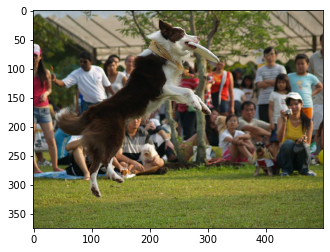

Caption: dog is jumping up to catch red


In [68]:
z = 100
pic = list(features.keys())[z]
image = features[pic].reshape((1,2048))
x = plt.imread(images+pic)
plt.imshow(x)
plt.show()
print("Caption:", Image_Caption(image))

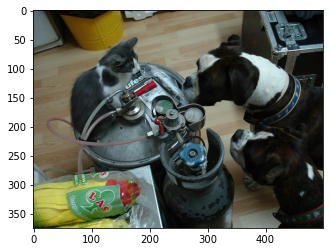

Caption: fat dog is drinking water from water


In [69]:
z = 1000
pic = list(features.keys())[z]
image = features[pic].reshape((1,2048))
x = plt.imread(images+pic)
plt.imshow(x)
plt.show()
print("Caption:", Image_Caption(image))

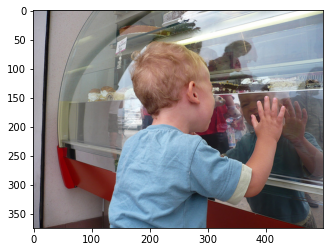

Caption: fat woman in black dress is sitting on the curb next to an orange


In [70]:
z = 500
pic = list(features.keys())[z]
image = features[pic].reshape((1,2048))
x = plt.imread(images+pic)
plt.imshow(x)
plt.show()
print("Caption:", Image_Caption(image))

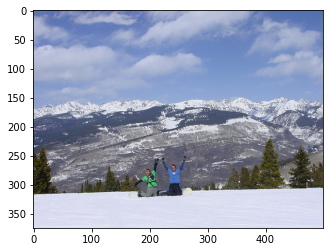

Caption: climber is climbing up snowy


In [71]:
z = 750
pic = list(features.keys())[z]
image = features[pic].reshape((1,2048))
x = plt.imread(images+pic)
plt.imshow(x)
plt.show()
print("Caption:", Image_Caption(image))

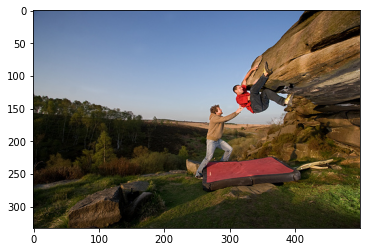

Caption: rock climber dangling from


In [72]:
z = 2020
pic = list(features.keys())[z]
image = features[pic].reshape((1,2048))
x = plt.imread(images+pic)
plt.imshow(x)
plt.show()
print("Caption:", Image_Caption(image))

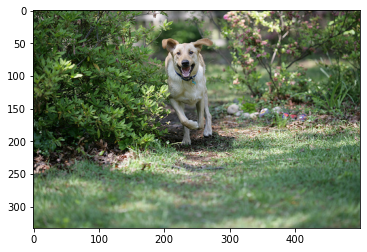

Caption: training this is running through field of


In [73]:
z = 2022
pic = list(features.keys())[z]
image = features[pic].reshape((1,2048))
x = plt.imread(images+pic)
plt.imshow(x)
plt.show()
print("Caption:", Image_Caption(image))

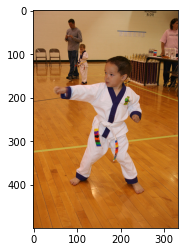

Caption: sword training


In [74]:
z = 2042
pic = list(features.keys())[z]
image = features[pic].reshape((1,2048))
x = plt.imread(images+pic)
plt.imshow(x)
plt.show()
print("Caption:", Image_Caption(image))

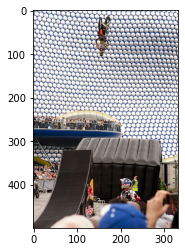

Caption: 


In [75]:
z = 6969
pic = list(features.keys())[z]
image = features[pic].reshape((1,2048))
x = plt.imread(images+pic)
plt.imshow(x)
plt.show()
print("Caption:", Image_Caption(image))

### Coincidence ? I think not 

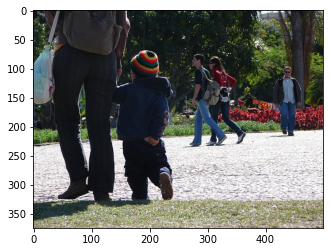

Caption: uniformed couple walking down the


In [76]:
z = 7999
pic = list(features.keys())[z]
image = features[pic].reshape((1,2048))
x = plt.imread(images+pic)
plt.imshow(x)
plt.show()
print("Caption:", Image_Caption(image))

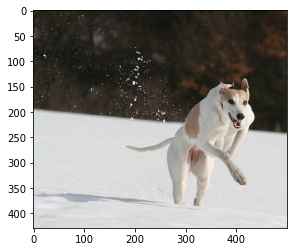

Caption: thin dog is running through the


In [78]:
z = 10
pic = list(features.keys())[z]
image = features[pic].reshape((1,2048))
x = plt.imread(images+pic)
plt.imshow(x)
plt.show()
print("Caption:", Image_Caption(image))

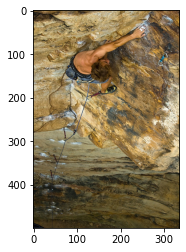

Caption: many people are rafting on rocks by


In [79]:
z = 333
pic = list(features.keys())[z]
image = features[pic].reshape((1,2048))
x = plt.imread(images+pic)
plt.imshow(x)
plt.show()
print("Caption:", Image_Caption(image))

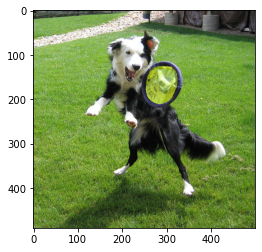

Caption: training training lies on the


In [80]:
z = 50
pic = list(features.keys())[z]
image = features[pic].reshape((1,2048))
x = plt.imread(images+pic)
plt.imshow(x)
plt.show()
print("Caption:", Image_Caption(image))

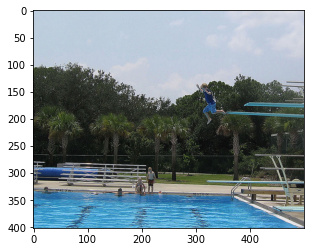

Caption: diving into the


In [81]:
z = 45
pic = list(features.keys())[z]
image = features[pic].reshape((1,2048))
x = plt.imread(images+pic)
plt.imshow(x)
plt.show()
print("Caption:", Image_Caption(image))